#### Load Libraries

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc

from sklearn.linear_model import LogisticRegression

### Load Data

In [20]:
# import data into a pandas dataframe
df = pd.read_csv('telco_customer_churn.csv')
df.head()

,customer_ID,gender,senior_citizen,partner,dependents,tenure,phone_Service,multiple_lines,internet,security_online,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type,paperless_billing,payment_mode,charges_per_month,charges_total,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Exploratory Data Analysis

You can leverage what done in one of the previous assignments, recreate it and expand it.

#### Clean data

In [21]:
# Reassign dtypes
df["customer_ID"] = df["customer_ID"].astype("string")
df["gender"] = df["gender"].astype("category")
df["senior_citizen"] = df["senior_citizen"].astype("category")
df["partner"] = df["partner"].astype("category")
df["dependents"] = df["dependents"].astype("category")
df["tenure"] = df["tenure"].astype(int)
df["phone_Service"] = df["phone_Service"].astype("category")
df["multiple_lines"] = df["multiple_lines"].astype("category")
df["internet"] = df["internet"].astype("category")
df["security_online"] = df["security_online"].astype("category")
df["backup_online"] = df["backup_online"].astype("category")
df["device_protection"] = df["device_protection"].astype("category")
df["tech_support"] = df["tech_support"].astype("category")
df["streaming_tv"] = df["streaming_tv"].astype("category")
df["streaming_movies"] = df["streaming_movies"].astype("category")
df["contract_type"] = df["contract_type"].astype("category")
df["paperless_billing"] = df["paperless_billing"].astype("category")
df["payment_mode"] = df["payment_mode"].astype("category")
df["churn"] = df["churn"].astype("category")

In [22]:
# Check number of blank strings
df["charges_total"] = df["charges_total"].apply(lambda s: s.strip())
print((df["charges_total"] == "").sum())

df[["tenure", "charges_total"]][df["charges_total"] == ""]

11


,tenure,charges_total
488,0,
753,0,
936,0,
1082,0,
1340,0,
3331,0,
3826,0,
4380,0,
5218,0,
6670,0,


In [23]:
# Replace blank strings with 0 as empty strings are used for clients <1 month in tenture, some string could be "  " and not just "", so we also strip whitespaces.
df["charges_total"] = df["charges_total"].replace("", 0)

# Convert to the float dtype
df["charges_total"] = df["charges_total"].astype(float)

In [24]:
# Standardise to Yes / No for senior citizen
df["senior_citizen"] = df["senior_citizen"].apply(lambda x: "Yes" if x == 1 else "No")
df["senior_citizen"] = df["senior_citizen"].astype("category")

In [25]:
# Drop NAs, if any
df.isna().sum()

customer_ID          0
gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_Service        0
multiple_lines       0
internet             0
security_online      0
backup_online        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract_type        0
paperless_billing    0
payment_mode         0
charges_per_month    0
charges_total        0
churn                0
dtype: int64

In [26]:
# Check dtypes
df.dtypes

customer_ID            string
gender               category
senior_citizen       category
partner              category
dependents           category
tenure                  int32
phone_Service        category
multiple_lines       category
internet             category
security_online      category
backup_online        category
device_protection    category
tech_support         category
streaming_tv         category
streaming_movies     category
contract_type        category
paperless_billing    category
payment_mode         category
charges_per_month     float64
charges_total         float64
churn                category
dtype: object

### Univariate analysis of categorical variables

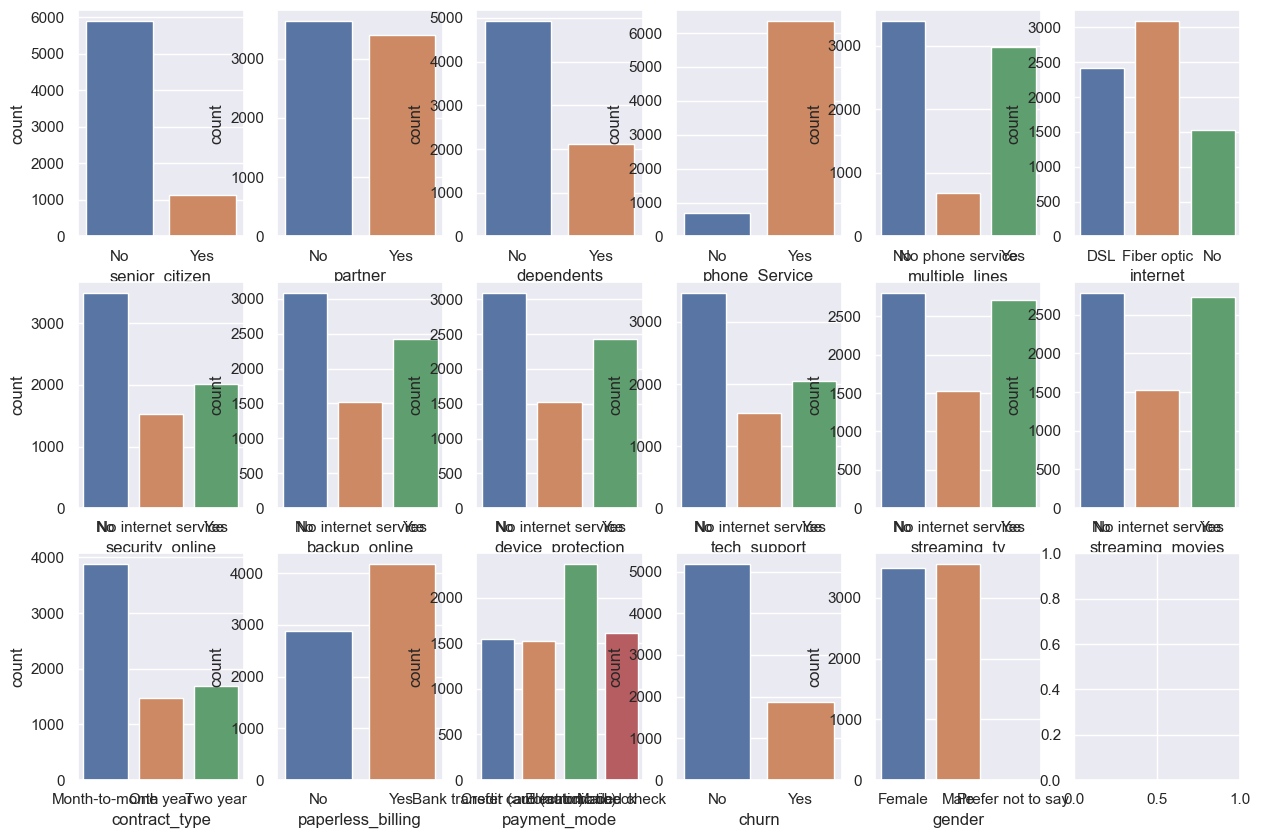

In [27]:
fig, ax = plt.subplots(3, 6)
sns.set(rc={'figure.figsize':(40,24)})

# First row
sns.countplot(x = "senior_citizen", data = df, ax = ax[0, 0])
sns.countplot(x = "partner", data = df, ax = ax[0, 1])
sns.countplot(x = "dependents", data = df, ax = ax[0, 2])
sns.countplot(x = "phone_Service", data = df, ax = ax[0, 3])
sns.countplot(x = "multiple_lines", data = df, ax = ax[0, 4])
sns.countplot(x = "internet", data = df, ax = ax[0, 5])

# Second row
sns.countplot(x = "security_online", data = df, ax = ax[1, 0])
sns.countplot(x = "backup_online", data = df, ax = ax[1, 1])
sns.countplot(x = "device_protection", data = df, ax = ax[1, 2])
sns.countplot(x = "tech_support", data = df, ax = ax[1, 3])
sns.countplot(x = "streaming_tv", data = df, ax = ax[1, 4])
sns.countplot(x = "streaming_movies", data = df, ax = ax[1, 5])

# Third row
sns.countplot(x = "contract_type", data = df, ax = ax[2, 0])
sns.countplot(x = "paperless_billing", data = df, ax = ax[2, 1])
sns.countplot(x = "payment_mode", data = df, ax = ax[2, 2])
sns.countplot(x = "churn", data = df, ax = ax[2, 3])
sns.countplot(x = "gender", data = df, ax = ax[2, 4])

plt.show()

#### Some observations of univariate analysis of categorical variables:
senior_citizen, phone_service, dependents, gender, multiple_lines all have more disproportionate categories (i.e. the ratio of "no" to "yes" or vice versa is higher than other categorical variables).

Quite a few categories contain the category where the customers do not subscribe to internet service. Those who do not subscribe to internet service is not an insignificant proportion of the customer base. 

The number of customers who churn is less than half of those who don't churn.

### Univariate analysis of continuous variables
We use histograms and boxplot to look at the distribution as they are continuous in nature.

In [28]:
df[["tenure", "charges_per_month", "charges_total"]].describe()

,tenure,charges_per_month,charges_total
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


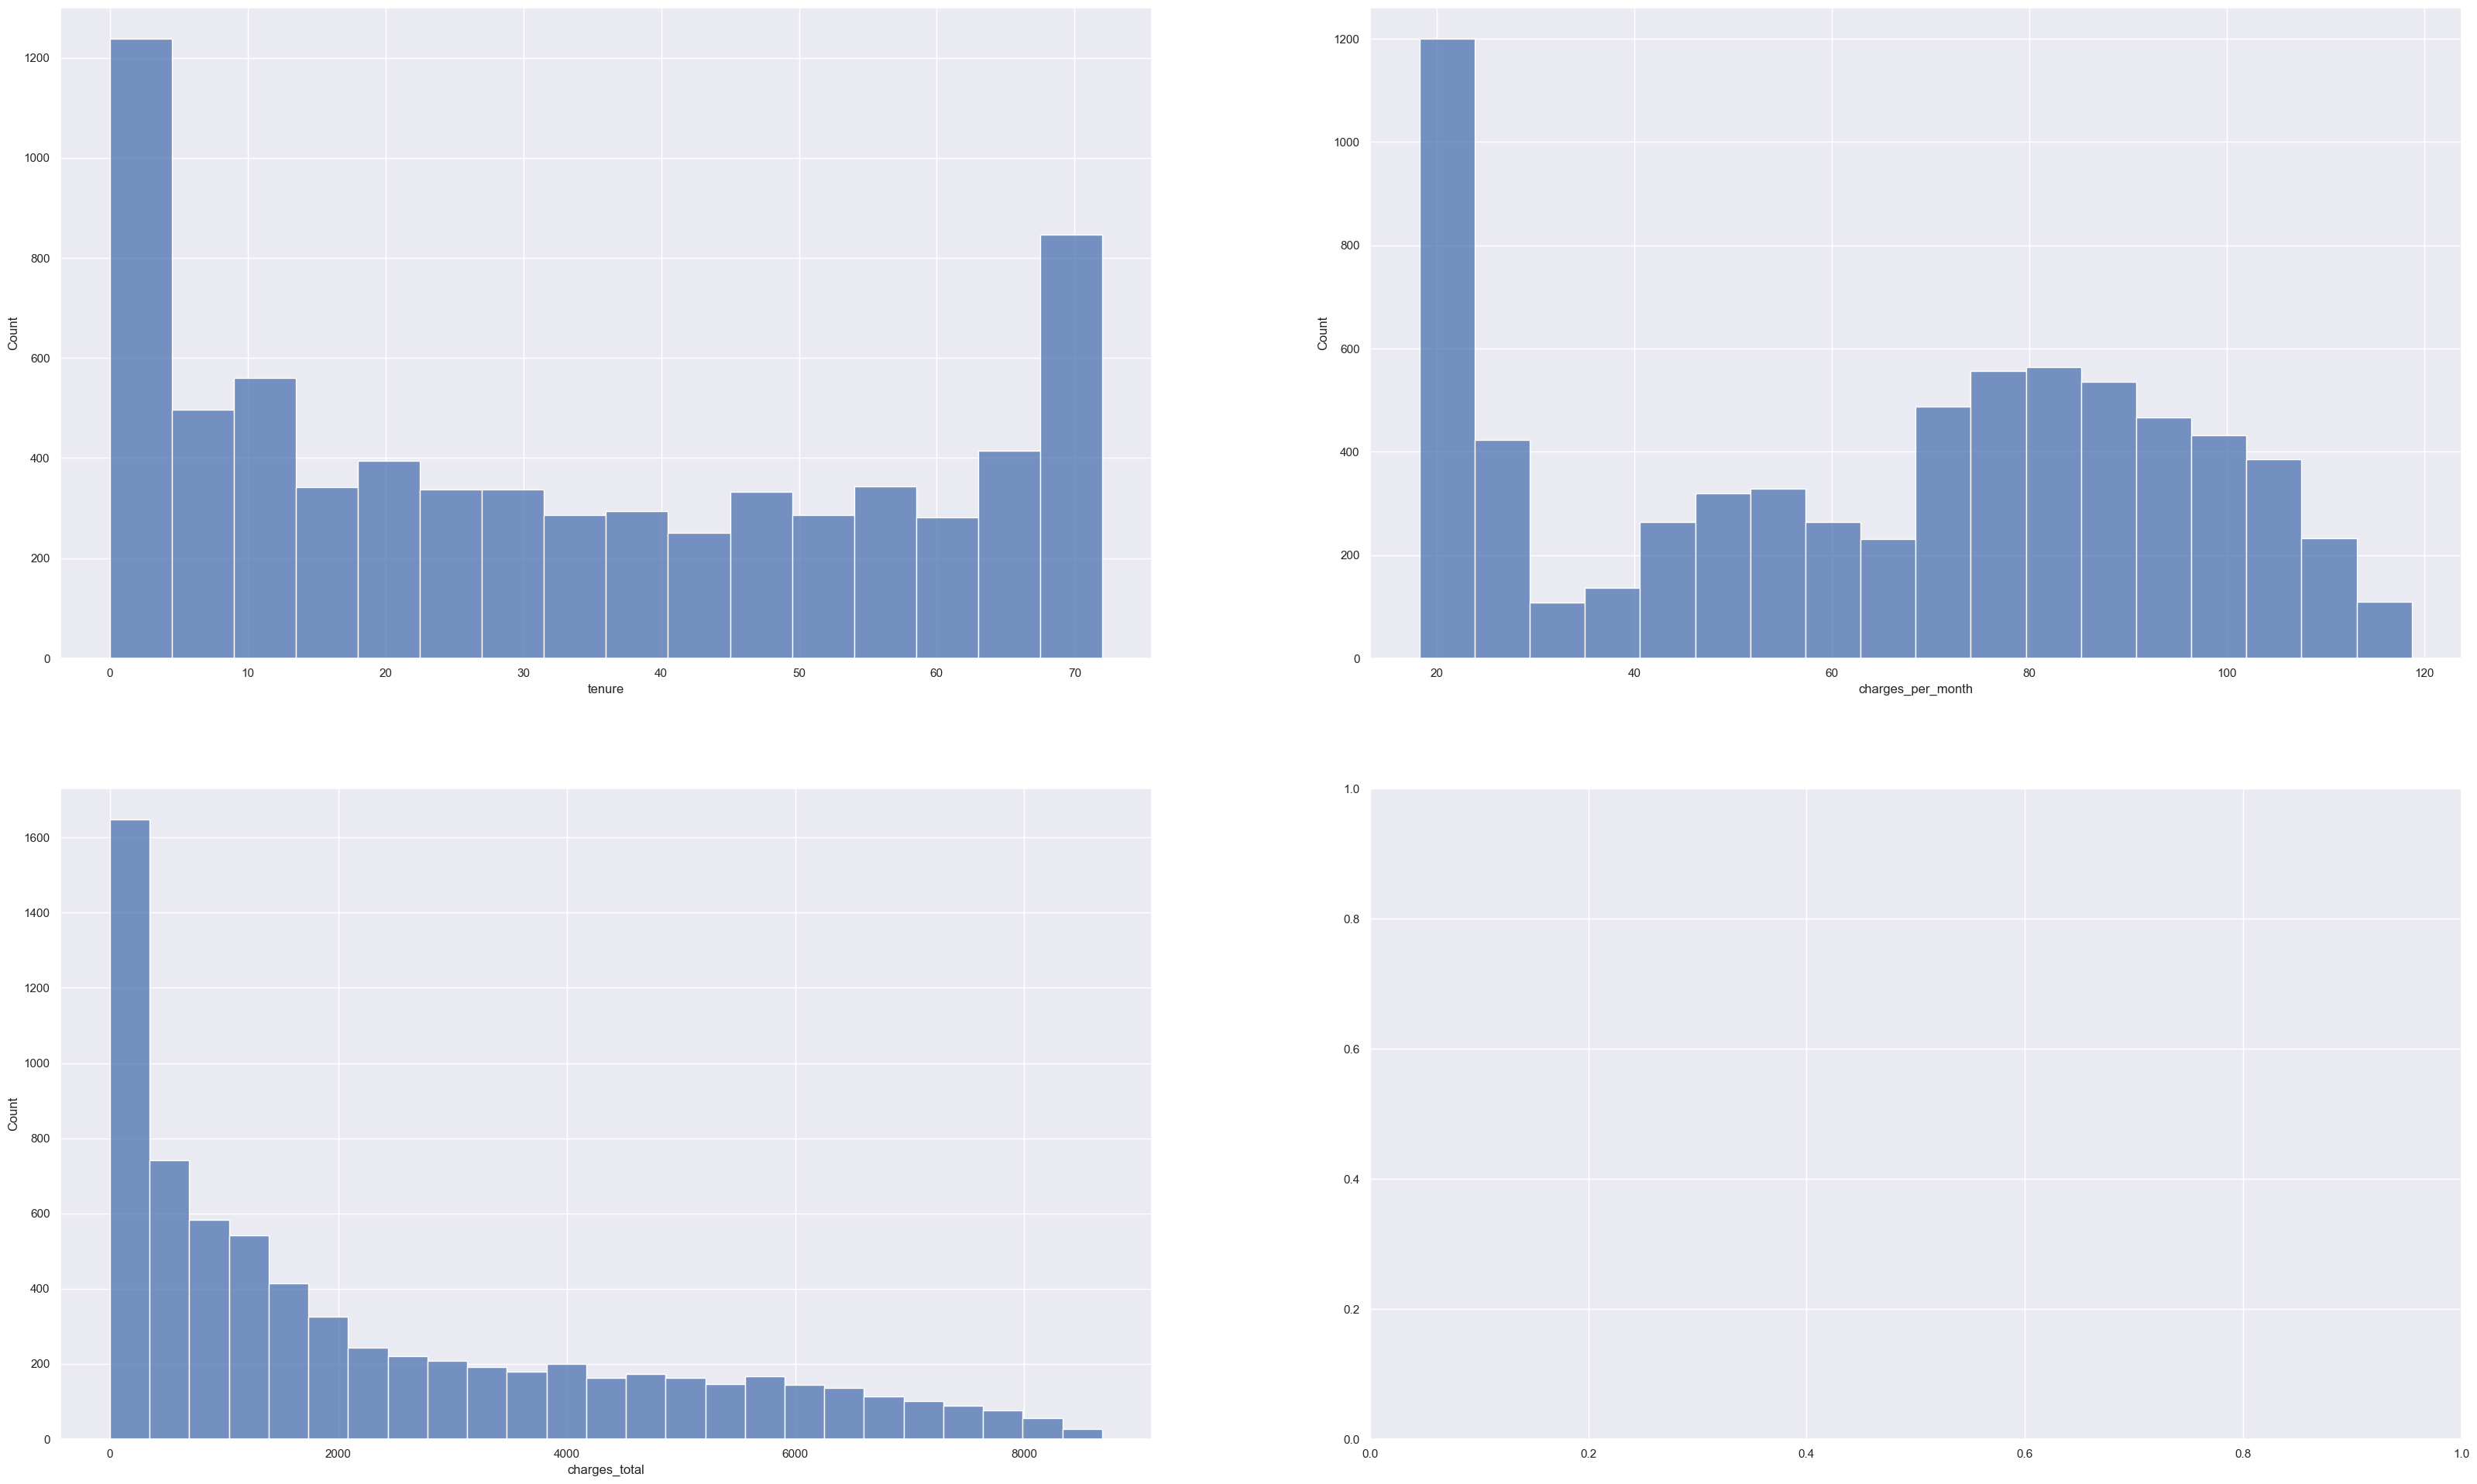

In [29]:
fig, ax = plt.subplots(2, 2)
sns.set(rc={'figure.figsize':(10,8)})

sns.histplot(x = "tenure", data = df, ax = ax[0, 0])
sns.histplot(x = "charges_per_month", data = df, ax = ax[0, 1])
sns.histplot(x = "charges_total", data = df, ax = ax[1, 0])
plt.show()

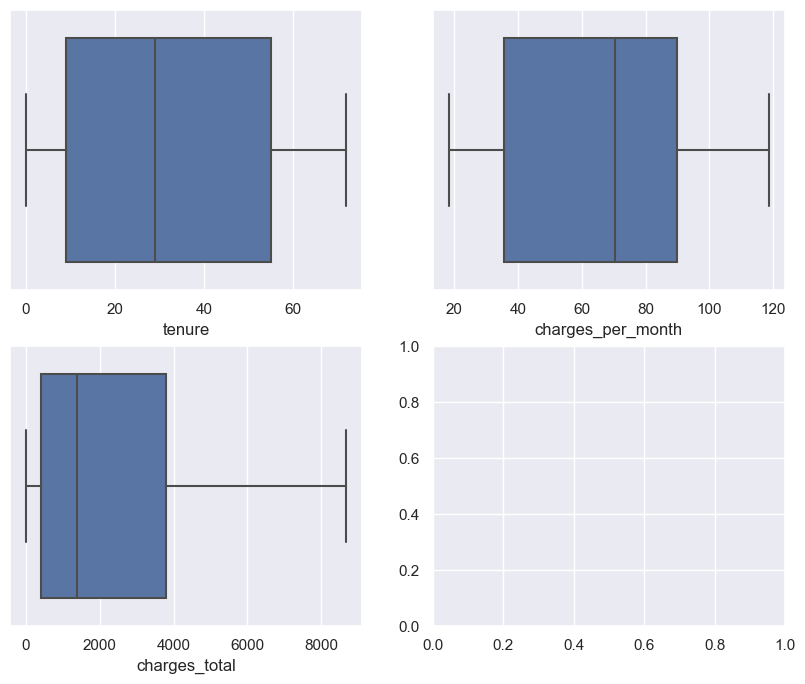

In [30]:
fig, ax = plt.subplots(2, 2)
sns.set(rc={'figure.figsize':(15,8)})

sns.boxplot(x = "tenure", data = df, ax = ax[0, 0])
sns.boxplot(x = "charges_per_month", data = df, ax = ax[0, 1])
sns.boxplot(x = "charges_total", data = df, ax = ax[1, 0])
plt.show()

#### Some observations of univariate analysis of continuous variables:
Tenure seems to be bimodal, with peaks with very loyal customers (>70 months stayed with company) and very short term customers (<5 months stayed with company). It has high kurtosis since the modes are at both ends.

Charges per month seem to be left skew, with many customers at 20 charges per month. It has high kurtosis as it many low outliers, but not as much as total charges since aside from the outliers, the distribution still approximates a normal distribution.

Total charges has a right skew, with many customers with low charges but a few outliers. It has high kurtosis as it has many low outliers

### Bivariate EDA of categorical variables with target (churn)
We want to compare the proportion of each category that churn vs not churned.

If there is a big disparity between the number of customers that churn for each category, then there could be some correlation with that particular category and the likelihood of similar customers churning in the future.

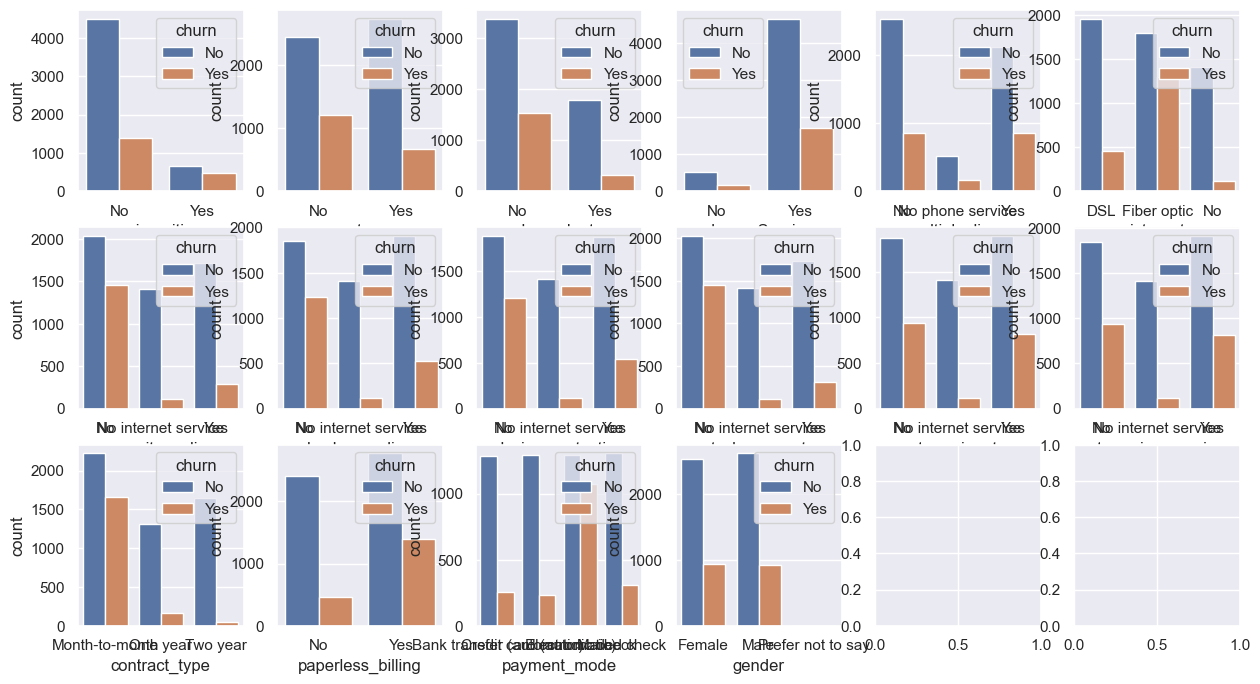

In [31]:
fig, ax = plt.subplots(3, 6)
sns.set(rc={'figure.figsize':(30,14)})

# First row
sns.countplot(x = "senior_citizen", hue = "churn", data = df, ax = ax[0, 0])
sns.countplot(x = "partner", hue = "churn", data = df, ax = ax[0, 1])
sns.countplot(x = "dependents", hue = "churn", data = df, ax = ax[0, 2])
sns.countplot(x = "phone_Service", hue = "churn", data = df, ax = ax[0, 3])
sns.countplot(x = "multiple_lines", hue = "churn", data = df, ax = ax[0, 4])
sns.countplot(x = "internet", hue = "churn", data = df, ax = ax[0, 5])

# Second row
sns.countplot(x = "security_online", hue = "churn", data = df, ax = ax[1, 0])
sns.countplot(x = "backup_online", hue = "churn", data = df, ax = ax[1, 1])
sns.countplot(x = "device_protection", hue = "churn", data = df, ax = ax[1, 2])
sns.countplot(x = "tech_support", hue = "churn", data = df, ax = ax[1, 3])
sns.countplot(x = "streaming_tv", hue = "churn", data = df, ax = ax[1, 4])
sns.countplot(x = "streaming_movies", hue = "churn", data = df, ax = ax[1, 5])

# Third row
sns.countplot(x = "contract_type", hue = "churn", data = df, ax = ax[2, 0])
sns.countplot(x = "paperless_billing", hue = "churn", data = df, ax = ax[2, 1])
sns.countplot(x = "payment_mode", hue = "churn", data = df, ax = ax[2, 2])
sns.countplot(x = "gender", hue = "churn", data = df, ax = ax[2, 3])

plt.show()

#### Some observations of bivariate analysis of categorical variables and target (churn)
Where the customer is a senior citizen, subscribes to fibre optic internet, no security online, no backup online, no device protection, no tech support, month to month contract type, paperless billing, payment by electronic check seem to have the highest likelihood of churn.

We can see this by comparing the relatively low difference in numbers of customers churning within the "yes" and "no" or "no internet service" categories for each variable.

Whereas those who do not have internet service across the different categories seem to have a lower likelihood of churn.

Interestingly, whether customers have partners, or have multiple phone lines, or use DSL vs no internet, or have streaming tv, or have streaming movies, or regardless their gender, seem to have low correlation with whether these customers eventually churn. 

So maybe customers are more satisfied with these products, and customers are less satisfied with other categories that have a higher likelihood of churn.

#### Bivariate EDA of continuous data with target

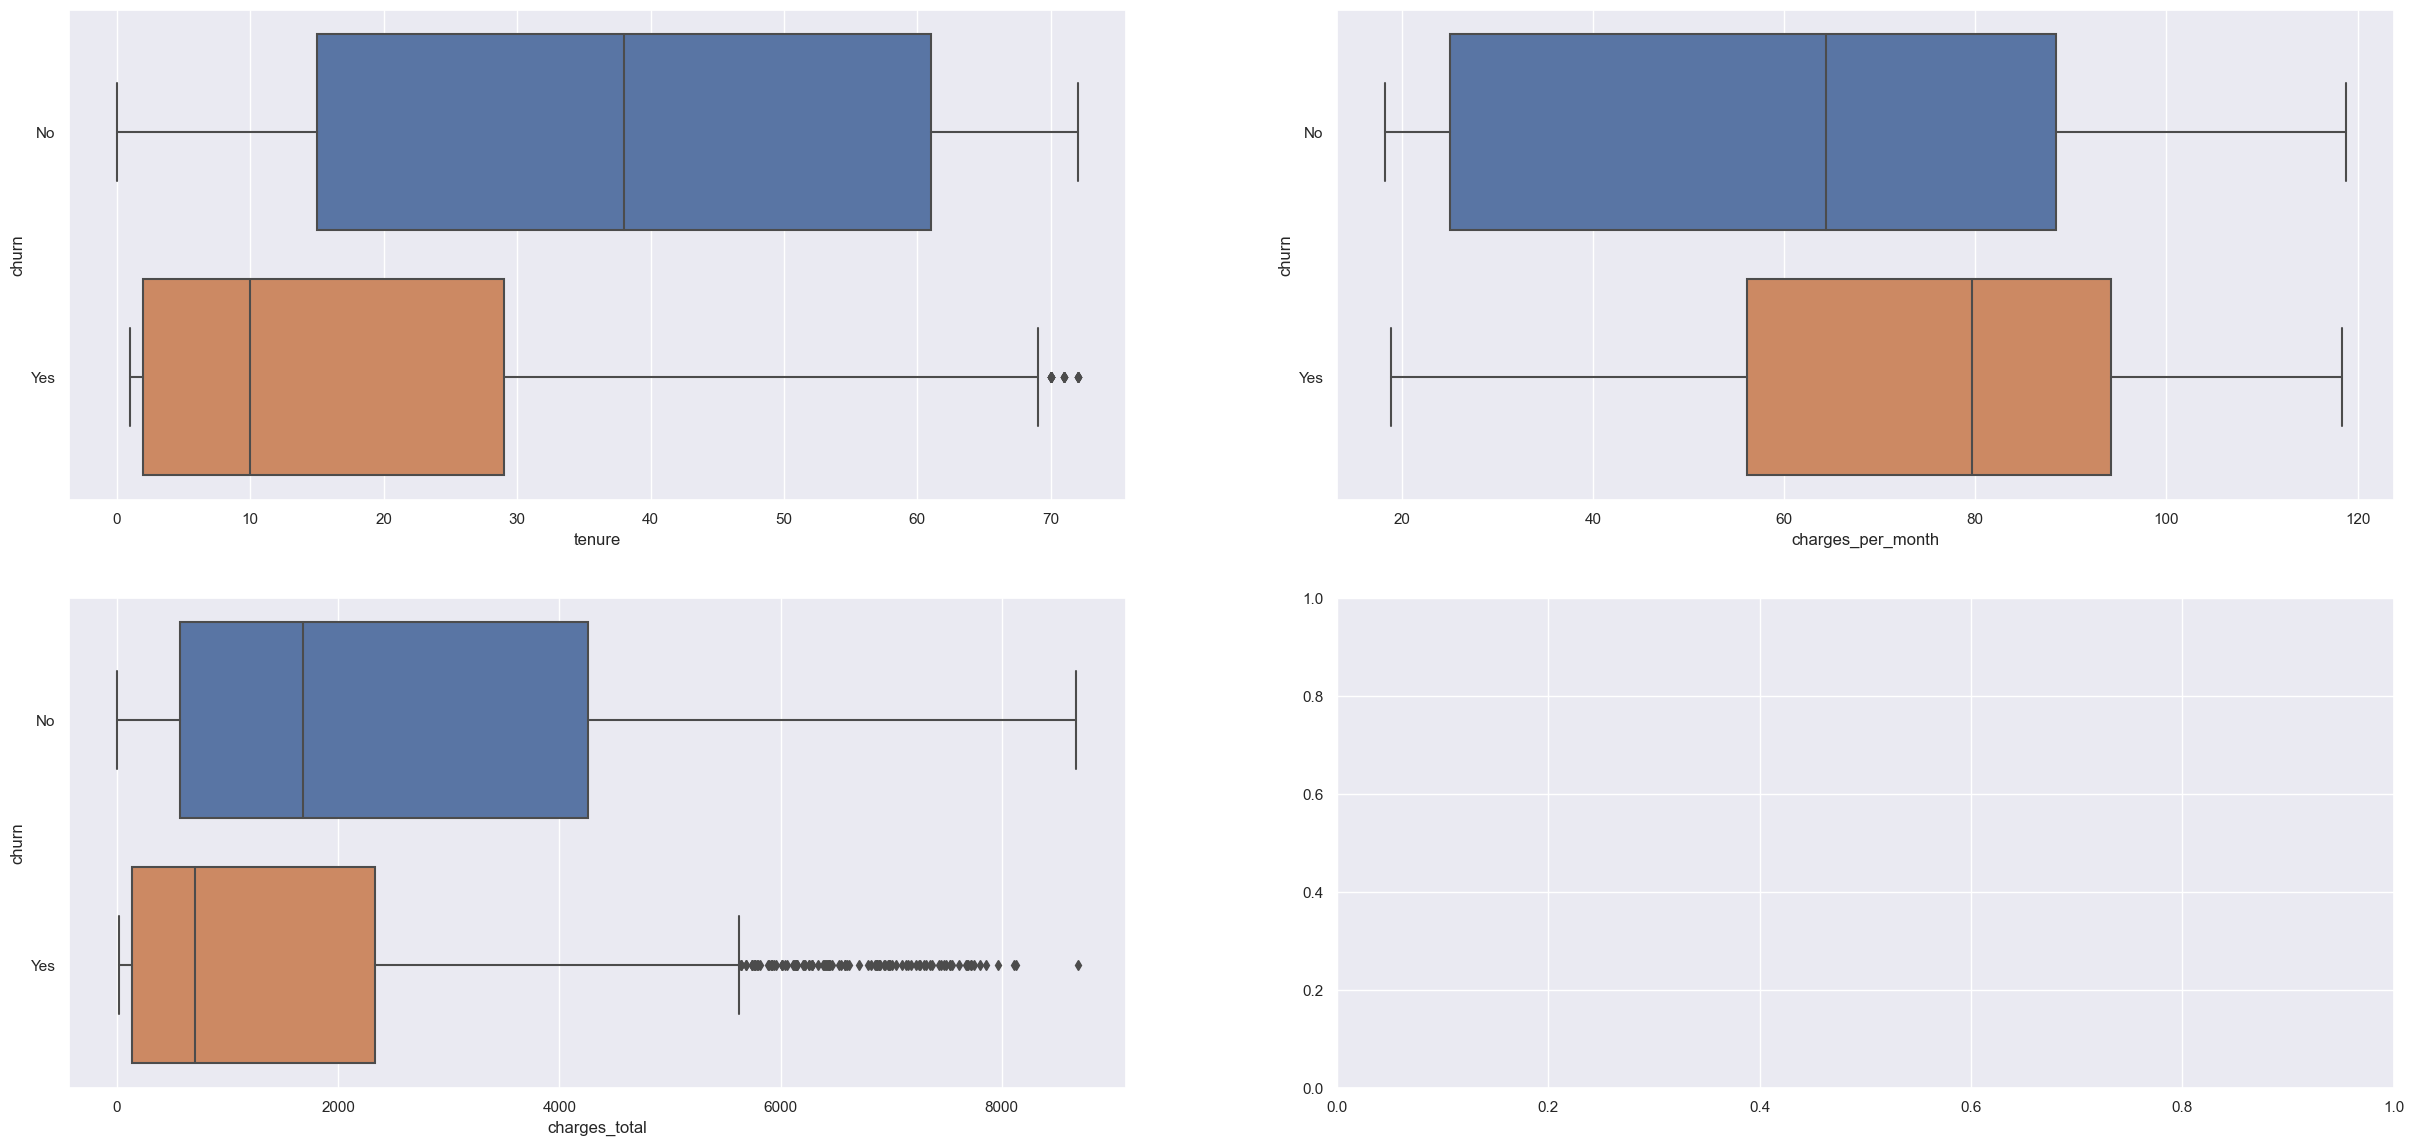

In [32]:
fig, ax = plt.subplots(2, 2)
sns.set(rc={'figure.figsize':(15,10)})

sns.boxplot(x = "tenure", y = "churn", data = df, ax = ax[0, 0])
sns.boxplot(x = "charges_per_month", y = "churn", data = df, ax = ax[0, 1])
sns.boxplot(x = "charges_total", y = "churn", data = df, ax = ax[1, 0])

plt.show()

#### Some observations
Seems that there is a correlation between low total charges (median <\$500), short tenure (median <10 months), and high charges per month (median >\$80) with those customers who churn.

Though there are still many outliers with high total charges and these customers still end up churnning. So just because a customer has low total charges does not make him more likely to churn.

### Feature Engineering and Analysis
Think about any possible feature that is predictive of the target.  
Measure how each feature is predictive of the target and select all those relevant for the model.

In [33]:
# Get dummies for categorical variables

# Drop churn and customer id
x = df.drop(["customer_ID", "churn"], axis = 1)

# Choose columns that are categorical
cat_vars = x.select_dtypes(include=['category'])

# Onehotencode categorical variables
x_dummies = pd.get_dummies(cat_vars)

# Return the remainder of non-categorical variables and then concatenate with the ohe features
non_cat_vars = x[x.columns.difference(cat_vars.columns)]
x = non_cat_vars.join(x_dummies)
x.head()

,charges_per_month,charges_total,tenure,gender_Female,gender_Male,gender_Prefer not to say,senior_citizen_No,senior_citizen_Yes,partner_No,partner_Yes,...,streaming_movies_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,paperless_billing_No,paperless_billing_Yes,payment_mode_Bank transfer (automatic),payment_mode_Credit card (automatic),payment_mode_Electronic check,payment_mode_Mailed check
0,29.85,29.85,1,1,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,56.95,1889.50,34,0,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,53.85,108.15,2,0,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,42.30,1840.75,45,0,1,0,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,70.70,151.65,2,1,0,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [34]:
# Create target with churn
y = df["churn"].apply(lambda x: 1 if x == "Yes" else 0)
y = y.astype(int)

#### Do Backward stepwise regression

Greedy algorithm, fitting logistic regression, selecting on highest recall to do feature selection

We use recall instead of precision because we are more concerned with the risk of not identifying customers who do end up churning (false negatives). So higher recall means fewer false negatives, so we want to optimise the model that produces the highest recall.

We use backwards stepwise regression, starting from all 47 possible features, and we look to choose 10% of these features (as an approximate benchmark). By choosing the most important features, we could improve model performance and also make the model easier to interpret with fewer features.

We use backwards selection instead of forwards, as the algorithm for forward selection selects features by the order in the dataset, and so every new feature would likely increase recall, even if there are not important features.

In [35]:
lr = LogisticRegression(n_jobs=-1, random_state=0)

# This performs stepwise regression, selecting for 10% of available features
# Start from the back so that we are not influenced by the sequence of features available
# Use 3 fold CV to reduce computation time
sfs = SequentialFeatureSelector(lr, n_features_to_select=0.1, scoring = 'recall', n_jobs = -1, direction = "backward", cv = 3)

In [36]:
smote = SMOTE(random_state=42)

In [42]:
x_resampled, y_resampled = smote.fit_resample(x, y)

In [46]:
# Since we have a class imbalance, we make sure that the training and test set accurately represents the distribution of churn vs non-churn customers.
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=0)

In [47]:
# Feature selection on the training dataset so that we have a hold out dataset for validating model performace later with the reduced feature set
sfs = sfs.fit(x_train, y_train)

In [48]:
# To print features which were selected by backward selection
selected_features = [b for a, b in zip(sfs.support_, x_train.columns.to_list()) if a]
print(selected_features)

['streaming_movies_No internet service', 'contract_type_One year', 'contract_type_Two year', 'payment_mode_Credit card (automatic)']


In [94]:
# Subset for the resampled dataset according to the selected features
x_subset_resampled = x_resampled[selected_features]
x_subset_resampled.head()

,streaming_movies_No internet service,contract_type_One year,contract_type_Two year,payment_mode_Credit card (automatic)
0,0,0,0,0
1,0,1,0,0
2,0,0,0,0
3,0,1,0,0
4,0,0,0,0


In [92]:
# Subset for the original dataset according to the selected features
x_subset = x[selected_features]
x_subset.head()

,streaming_movies_No internet service,contract_type_One year,contract_type_Two year,payment_mode_Credit card (automatic)
0,0,0,0,0
1,0,1,0,0
2,0,0,0,0
3,0,1,0,0
4,0,0,0,0


#### Analysis of the top 4 most important features

The selected important features by stepwise regression corresponds with the bivariate analysis above: we see strong correlation in each of these features individually with churn, as seen in the boxplots for the continuous variables (total charges and tenure), and the difference in the proportions for the churn and no churn customers countplots for no security online and month to month cotnrac type.

So it is not surprising that the selected 4 most important features can also be visualised to have high correlation with churn.

### Configure the model using an appropriate classification technique

We want to consider performance model more from the precision / recall curve more than other metrics, since the we have a class imbalanace in the dataset (fewer churn customers than non-churn). So precision / recall considers the impact of true negatives more than the ROC.

First we consider a model with all the features for baseline performance and compare with the model with the top 4 most important features after feature selection.

### Model with all of the features to compare baseline performance

In [76]:
# Train on the oversampled data, test on the original pre-sampled data
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=0)

In [77]:
lr = LogisticRegression(n_jobs=-1, random_state=0)
lr = lr.fit(x_train, y_train)

In [79]:
# Test on the oversampled dataset
y_pred = lr.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1033
           1       0.83      0.85      0.84      1037

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



In [80]:
# Test on the original dataset
y_pred = lr.predict(x)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      5174
           1       0.56      0.67      0.61      1869

    accuracy                           0.77      7043
   macro avg       0.72      0.74      0.73      7043
weighted avg       0.79      0.77      0.78      7043



In [87]:
# Predict probabilities to calculate RUC
y_pred_proba = lr.predict_proba(x)

#### Interpretation
The model performance is not the best in terms of reducing false negatives when identifying churn customers, as seen by 55% recall for the positive class. This is just slightly over 50% of randomly guessing.

But at least in terms of the weighted average which considers predictions for the negative class too, recall is at 80%. So the model is more able to distinguish non-churn customers than churn customers.

### ROC curve

In [88]:
# keep probabilities for the positive outcome only
lr_probs = y_pred_proba[:, 1]

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y))]

# calculate scores
ns_auc = roc_auc_score(y, ns_probs)
lr_auc = roc_auc_score(y, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.828


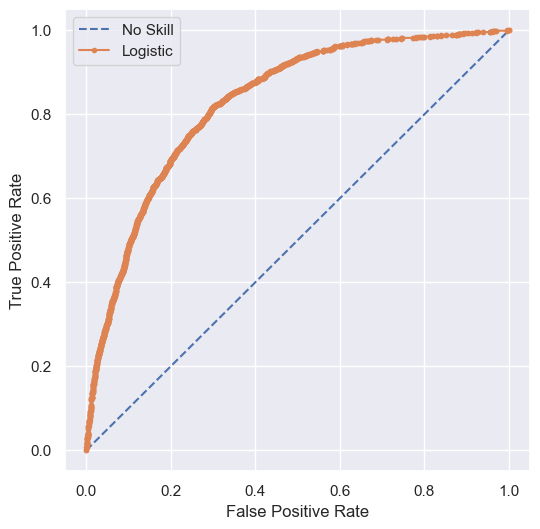

In [89]:
sns.set(rc={'figure.figsize':(6,6)})

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

#### Interpretation

The AUC is 0.85, which is substantially higher than randomly guessing (0.5). The curve is also close to the top left corner of the graph, showing that this classifier has reasonable performance.

### Precision recall curve

In [90]:
lr_precision, lr_recall, _ = precision_recall_curve(y, lr_probs)
lr_f1, lr_auc = f1_score(y, y_pred), auc(lr_recall, lr_precision)

# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
no_skill = len(y[y==1]) / len(y)

Logistic: f1=0.612 auc=0.616


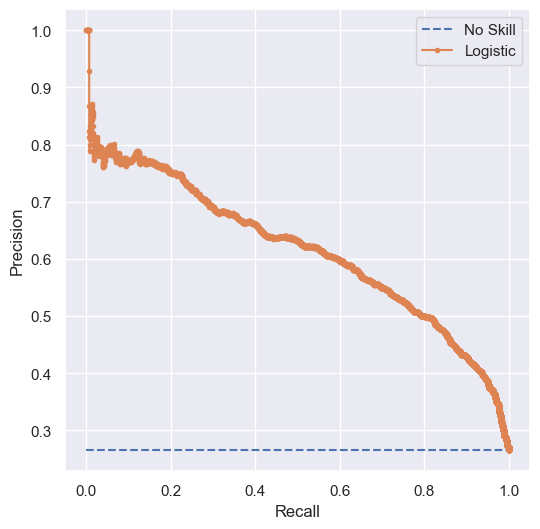

In [91]:
sns.set(rc={'figure.figsize':(6,6)})

plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the legend
plt.legend()

# show the plot
plt.show()

#### Interpretation
This model is generally ok in terms of the trade-off between precision / recall with AUC at 0.652 which is somewhat higher than 0.5 (a baseline random classifier). 

The curve is somewhat following the top right corner of the plot too. So there is ok performance, but not the best.

This curve better accounts for false negatives, as stated we are more concerned with reducing false negatives, and so we want to increase recall.

### Model with reduced features

In [95]:
# Split dataset again according to the subset
x_train, x_test, y_train, y_test = train_test_split(x_subset_resampled, y_resampled, test_size=0.2, random_state=0)

In [96]:
lr = LogisticRegression(n_jobs=-1, random_state=0)
lr = lr.fit(x_train, y_train)

In [97]:
# Test according to the resampled dataset
y_pred = lr.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1033
           1       0.74      0.84      0.79      1037

    accuracy                           0.77      2070
   macro avg       0.78      0.77      0.77      2070
weighted avg       0.78      0.77      0.77      2070



In [99]:
# Test according to the original dataset
y_pred = lr.predict(x_subset)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.71      0.79      5174
           1       0.48      0.74      0.58      1869

    accuracy                           0.72      7043
   macro avg       0.68      0.73      0.69      7043
weighted avg       0.78      0.72      0.73      7043



In [101]:
# Predict probabilities to calculate ROC
y_pred_proba = lr.predict_proba(x_subset)

#### Interpretation
Even with the drastically reduced feature selection (n=4), we see that performance has not changed much (probably insignificant decrease). Recall has slightly increased for churn customers to 56%, while the weighted average recall is 78% (drop from 80%). Even the other metrics dropped by 1-2%, which is insignificant.

So just from comparing model performance alone, we can say that these 4 features contain most of the predictive power.

As to the roughly same model performance even after feature selection, perhaps one possible reason is that the classes are not linearly separable (as logistic regression is a linear classifier). This could be validated by trying out a decision tree classifier which makes no assumptions of linearity.

### Chose the correct metric for assessment of the model

### ROC curve

In [102]:
# keep probabilities for the positive outcome only
lr_probs = y_pred_proba[:, 1]

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y))]

# calculate scores
ns_auc = roc_auc_score(y, ns_probs)
lr_auc = roc_auc_score(y, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y, lr_probs)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.778


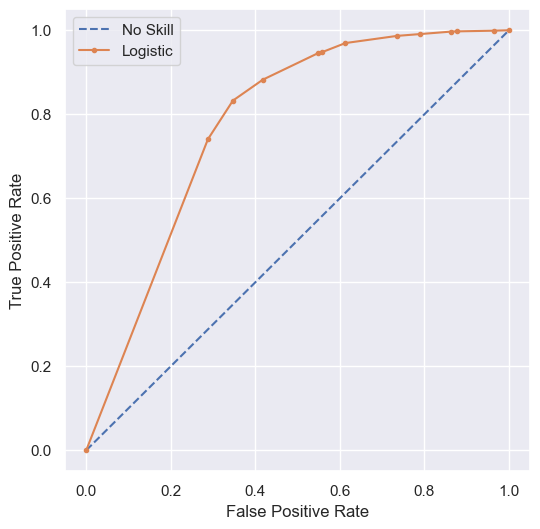

In [103]:
sns.set(rc={'figure.figsize':(6,6)})

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

#### Interpretation
Similarly to the model before feature selection, the AUC is 0.828, which is close to 0.85, and the curve is close to the top left corner. So performance is also similar.

### Precision recall curve

In [104]:
lr_precision, lr_recall, _ = precision_recall_curve(y, lr_probs)
lr_f1, lr_auc = f1_score(y, y_pred), auc(lr_recall, lr_precision)

# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
no_skill = len(y[y==1]) / len(y)

Logistic: f1=0.584 auc=0.659


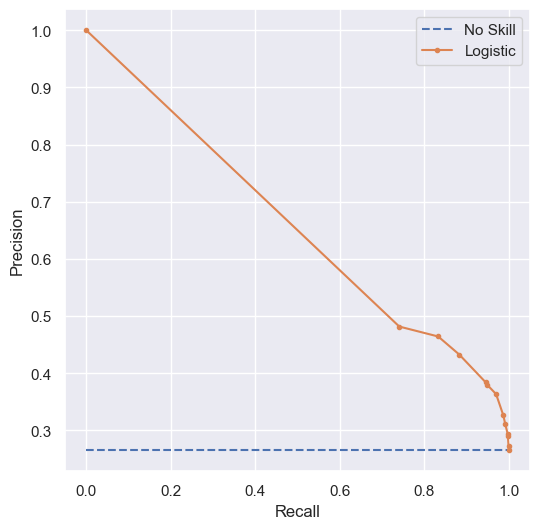

In [105]:
sns.set(rc={'figure.figsize':(6,6)})

plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the legend
plt.legend()

# show the plot
plt.show()

#### Interpretation
The performance is similar to the model before feature selection, with AUC at 0.628, compared to 0.652, and the shape of the curve is also roughly the same.

So overall, the performance of both models are similar across the performance metrics.

## General discussion

Seems like most of the explanatory power comes from the four features (or less) in the reduced dataset after feature selection: total charges, tenure, no security online and month to month contract type.

This can be seen in comparing the model performance in the ROC and precision recall curve for the model without any feature selection, with the model with feature selection. The performance is almost the same regardless of whether we prefer the performance assessed from ROC, or the precision recall curve: 

AUC for ROC curve is 0.850 (all features) vs 0.828 (reduced features), AUC for precision / recall curve is 0.652 (all features) vs 0.628 (reduced features). Even though we have reduced the dataset from 47 features after one-hot encoding, to 4 features after feature selection using stepwise backward regression, performance did not significantly change. So the explanatory power mostly comes from these 4 features (or less, given that stepwise regression was not done beyond the 4 features we have now).

Also considering we have accounted for the class imbalance with fewer churn customers by using a stratified split in dataset to account for class imbalance. 

Hence, we would prefer the simplified model with only 4 features as it is easier to explain and interpret, given that the performance is almost the same.